In [1]:
import contractions, re
from torchtext.data.utils import get_tokenizer

tokenizer_eng = get_tokenizer("spacy", language="en_core_web_sm")
tokenizer_spa = get_tokenizer("spacy", language="es_core_news_sm")

def tokenize(text, lang):
    """Standardize, tokenize and filter text."""
    text = text.replace("’", "'").replace("‘", "'").replace("´", "'") \
        .replace("“", '"').replace("”", '"').replace("´´", '"')
    tokens = tokenizer_eng(contractions.fix(text)) if lang == "eng" \
        else tokenizer_spa(text)  # lang == "spa"
    filtered_tokens = [token for token in tokens if re.match(
        r"""
        ^[a-zA-Z0-9áéíóúüñÁÉÍÓÚÜÑ.,!?¡¿]+  # 1+ allowed characters.
        (-[a-zA-Z0-9áéíóúüñÁÉÍÓÚÜÑ.,!?¡¿]+)*  # Optional hyphen plus chars.
        (_[a-zA-Z0-9áéíóúüñÁÉÍÓÚÜÑ.,!?¡¿]+)*  # Optional underscore plus chars.
        $  # End of the string.
        """,
        token,
        re.VERBOSE,
    )]
    return filtered_tokens

In [2]:
def corpus_iterator(filename, lang, sentence_number):
    """Read and tokenize sentences by iterating through a corpus file."""
    with open(filename, "r", encoding="utf-8") as file:
        for line in file:
            sentences = line.strip().split("\t")
            sentence = sentences[sentence_number]
            yield tokenize(sentence, lang)

In [3]:
from torchtext.vocab import build_vocab_from_iterator

def build_vocab(filename, lang, sentence_number, specials="<unk>", min_freq=5):
    """Build vocabulary."""
    vocab = build_vocab_from_iterator(
        corpus_iterator(filename, lang, sentence_number),
        min_freq=min_freq,
        specials=specials,
    )
    vocab.set_default_index(vocab[specials[-1]])
    return vocab

In [4]:
in_lang, out_lang = "eng", "spa"
filename = f"{in_lang}-{out_lang}.txt"
special_tokens = ["<pad>", "<sos>", "<eos>", "<unk>"]

in_vocab = \
    build_vocab(filename, in_lang, sentence_number=0, specials=special_tokens)
out_vocab = \
    build_vocab(filename, out_lang, sentence_number=1, specials=special_tokens)

In [5]:
import numpy as np

def all_words_in_vocab(sentence, vocab):
    """Check whether all words in a sentence are present in a vocabulary."""
    return all(word in vocab for word in sentence)

In [6]:
def pad(token_sequence, max_length=10):
    """Pad sequence of tokens."""
    padding_length = max_length - len(token_sequence)
    return ["<sos>"] + token_sequence + ["<eos>"] + ["<pad>"] * padding_length

In [7]:
def process(lines, in_lang, out_lang, in_vocab, out_vocab, max_length=10):
    """Process language corpus."""
    in_sequences, out_sequences = [], []
    for line in lines:
        sentences = line.strip().split("\t")
        in_tokens = tokenize(sentences[0], in_lang)
        out_tokens = tokenize(sentences[1], out_lang)

        if (all_words_in_vocab(in_tokens, in_vocab)
            and all_words_in_vocab(out_tokens, out_vocab)
            and len(in_tokens) <= max_length
            and len(out_tokens) <= max_length):
            
            padded_in_tokens = pad(in_tokens)
            in_sequence = in_vocab(padded_in_tokens)
            in_sequences.append(in_sequence)
            
            padded_out_tokens = pad(out_tokens)
            out_sequence = out_vocab(padded_out_tokens)
            out_sequences.append(out_sequence)

    return np.array(in_sequences), np.array(out_sequences)

In [8]:
import deeptrack as dt
import torch
from torch.utils.data import DataLoader

with open(filename, "r", encoding="utf-8") as file:
    inputs, outputs = process(file, in_lang, out_lang, in_vocab, out_vocab)

sources = dt.sources.Source(inputs=inputs, targets=outputs)
train_sources, test_sources = dt.sources.random_split(sources, [0.85, 0.15])

inputs_pip = dt.Value(sources.inputs) >> dt.pytorch.ToTensor(dtype=torch.int)
outputs_pip = dt.Value(sources.targets) >> dt.pytorch.ToTensor(dtype=torch.int)

train_dataset = \
    dt.pytorch.Dataset(inputs_pip & outputs_pip, inputs=train_sources)
test_dataset = \
    dt.pytorch.Dataset(inputs_pip & outputs_pip, inputs=test_sources)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [9]:
import deeplay as dl

class Seq2SeqEncoder(dl.DeeplayModule):
    """Sequence-to-sequence encoder."""

    def __init__(self, vocab_size, in_features=300, hidden_features=128,
                 hidden_layers=1, dropout= 0.0, bidirectional=True):
        """Initialize sequence-to-sequence encoder."""
        super().__init__()

        self.hidden_features = hidden_features
        self.hidden_layers = hidden_layers
        self.bidirectional = bidirectional
        self.embedding = dl.Layer(torch.nn.Embedding, vocab_size, in_features)
        self.rnn = dl.Layer(
            torch.nn.GRU,
            input_size=in_features,
            hidden_size=hidden_features,
            num_layers=hidden_layers,
            dropout=(0 if hidden_layers == 1 else dropout),
            bidirectional=bidirectional,
            batch_first=True,
        )

    def forward(self, inputs, hidden=None):
        """Perform forward pass."""
        inputs = self.embedding(inputs)
        outputs, hidden = self.rnn(inputs, hidden)
        if self.bidirectional:
            outputs = (
                outputs[:, :, :self.hidden_features]
                + outputs[:, :, self.hidden_features:]
            )
            hidden = hidden[: self.hidden_layers]
        return outputs, hidden

In [10]:
class Seq2SeqDecoder(dl.DeeplayModule):
    """Sequence-to-sequence decoder."""

    def __init__(self, vocab_size, in_features=300, hidden_features=128, 
                 hidden_layers=1, dropout=0.0):
        """Initialize sequence-to-sequence decoder."""
        super().__init__()

        ###self.in_features = in_features
        ###self.hidden_features = hidden_features
        ###self.num_layers = hidden_layers
        self.embedding = dl.Layer(torch.nn.Embedding, vocab_size, in_features)
        self.rnn = dl.Layer(
            torch.nn.GRU,
            input_size=in_features,
            hidden_size=hidden_features,
            num_layers=hidden_layers,
            bidirectional=False,
            batch_first=True,
            dropout=(0 if hidden_layers == 1 else dropout),
        )
        self.dense = dl.Layer(torch.nn.Linear, hidden_features, vocab_size)
        self.softmax = dl.Layer(torch.nn.Softmax, dim=-1)
        self.relu = dl.Layer(torch.nn.ReLU)

    def forward(self, x, hidden):
        """Perform forward pass."""
        x = self.embedding(x)
        x = self.relu(x)
        output, hidden = self.rnn(x, hidden)
        output = self.dense(output)
        output = self.softmax(output)
        return output, hidden

In [11]:
class Seq2SeqModel(dl.DeeplayModule):
    """Sequence-to-sequence model."""

    def __init__(self, in_vocab_size=None, out_vocab_size=None,
                 teacher_prob=1.0, embedding_dim=300, hidden_features=128,
                 hidden_layers=1, dropout=0.0, bidirectional=True):
        """Initialize the sequence-to-sequence model."""
        super().__init__()
        
        self.out_vocab_size = out_vocab_size
        self.teacher_prob = teacher_prob
        self.encoder = Seq2SeqEncoder(in_vocab_size, embedding_dim, \
            hidden_features, hidden_layers, dropout, bidirectional)
        self.decoder = Seq2SeqDecoder(out_vocab_size, embedding_dim, \
            hidden_features, hidden_layers, dropout)

    def forward(self, x):
        """Perform forward pass."""
        input, target = x
        
        encoder_outputs, encoder_hidden = self.encoder(input)
        
        decoder_hidden = encoder_hidden
        decoder_outputs = torch.zeros(
            (target.size(0), target.size(1), self.out_vocab_size)
        ).to(next(self.encoder.parameters()).device)

        for t in range(input.size(1)):
            if t == 0 or np.random.rand() < self.teacher_prob:
                decoder_input = target[:, t].unsqueeze(-1)
            else:
                decoder_input = topi.squeeze(-1).detach()

            decoder_input = \
                decoder_input.to(next(self.decoder.parameters()).device)
            decoder_output, decoder_hidden = \
                self.decoder(decoder_input, decoder_hidden)
            _, topi = decoder_output.topk(1)
            decoder_outputs[:, t, :] = decoder_output.squeeze(1)
        return decoder_outputs

    def evaluate(self, x):
        """Evaluate model."""
        with torch.no_grad():
            encoder_outputs, encoder_hidden = self.encoder(input)
        decoder_hidden = encoder_hidden
        outputs = torch.zeros(
            input.shape,
        ).to(next(self.encoder.parameters()).device)
        for t in range(input.size(1)):
            if t == 0:
                decoder_input = torch.full(
                    size=(input.size(0), 1),
                    fill_value=1,
                    device=next(self.encoder.parameters()).device,
                )
            else:
                decoder_input = topi.squeeze(-1).detach()

            decoder_input = decoder_input.to(next(self.decoder.parameters()).device)
            with torch.no_grad():
                decoder_output, decoder_hidden = self.decoder(
                    decoder_input,
                    decoder_hidden,
                )
            _, topi = decoder_output.topk(1)
            outputs[:, t] = topi.squeeze()

        return outputs

In [12]:
def maskedNLL(input, target, PADtoken=0):
    """Calculate the negative log-likelihood loss."""
    mask = target != PADtoken
    NLL = - torch.log(
        torch.gather(input.view(-1, input.shape[-1]), 1, target.view(-1, 1))
    )
    loss = NLL.masked_select(mask.view(-1, 1)).mean()
    return loss


In [13]:
class Seq2Seq(dl.Application):
    """Application for the sequence-to-sequence model."""

    def __init__(self, in_vocab, out_vocab, teacher_prob=1.0):
        """Initialize the application."""
        super().__init__(loss=maskedNLL, optimizer=dl.Adam(lr=1e-3))
        
        ###self.in_vocab = in_vocab
        ###self.in_vocab_size = len(in_vocab)
        ###self.out_vocab = out_vocab
        ###self.out_vocab_size = len(out_vocab)
        ###self.teacher_prob = teacher_prob
        self.model = Seq2SeqModel(
            in_vocab_size=len(in_vocab),
            out_vocab_size=len(out_vocab),
            teacher_prob=teacher_prob,
        )

    def train_preprocess(self, batch):
        """Adjust the target sequence by shifting it one position backward."""
        x = batch
        y = torch.cat((x[-1][:, 1:], x[-1][:, -1:]), dim=1)
        return x, y

    def forward(self, x):
        """Perform forward pass."""
        return self.model(x)

In [14]:
from torchtext.vocab import GloVe

embedding_dim = 300

glove = GloVe(name="42B", dim=embedding_dim, cache="./.vector_cache")
glove_embeddings_input = \
    glove.get_vecs_by_tokens(in_vocab.get_itos(), lower_case_backup=True)
glove_embeddings_target = \
    glove.get_vecs_by_tokens(out_vocab.get_itos(), lower_case_backup=True)

num_special_tokens = len(special_tokens)
glove_embeddings_input[1:num_special_tokens] = \
    torch.rand(num_special_tokens - 1, embedding_dim) * 0.01
glove_embeddings_target[1:num_special_tokens] = \
    torch.rand(num_special_tokens - 1, embedding_dim) * 0.01


INFO:torchtext.vocab.vectors:Loading vectors from ./.vector_cache/glove.42B.300d.txt.pt


In [15]:
seq2seq = Seq2Seq(
    in_vocab=in_vocab,
    out_vocab=out_vocab,
    teacher_prob=0.85,
)
seq2seq = seq2seq.create()

seq2seq.model.encoder.embedding.weight.data = glove_embeddings_input
seq2seq.model.encoder.embedding.weight.requires_grad = False
seq2seq.model.decoder.embedding.weight.data = glove_embeddings_target
seq2seq.model.decoder.embedding.weight.requires_grad = False

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ train_metrics │ MetricCollection │      0 │
│ 1 │ val_metrics   │ MetricCollection │      0 │
│ 2 │ test_metrics  │ MetricCollection │      0 │
│ 3 │ model         │ Seq2SeqModel     │  6.3 M │
│ 4 │ optimizer     │ Adam             │      0 │
└───┴───────────────┴──────────────────┴────────┘

Trainable params: 1.7 M                                                                                            
Non-trainable params: 4.6 M                                                                                        
Total params: 6.3 M                                                                                                
Total estimated model params size (MB): 25

Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


(<Figure size 1500x500 with 1 Axes>,
 array([[<Axes: title={'center': 'Loss'}, xlabel='Step'>]], dtype=object))

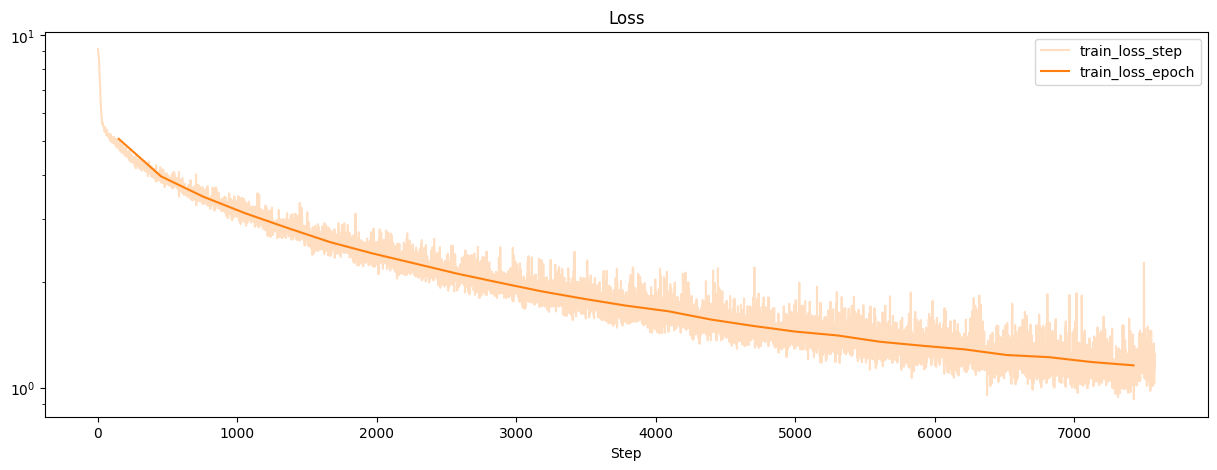

In [16]:
trainer = dl.Trainer(max_epochs=25, accelerator="auto")
trainer.fit(seq2seq, train_loader)
trainer.history.plot()

In [17]:
def unprocess(sequences, vocab):
    """Convert numeric sequences to sentences."""
    sentences = []
    for sequence in sequences:
        idxs = sequence[sequence > 2]
        words = [vocab.lookup_token(idx) for idx in idxs]
        sentences.append(" ".join(words))
    return sentences


In [18]:
def translate(source_text, model, in_lang, in_vocab, out_vocab):
    """Translate sentences."""
    query_tokens = tokenize(source_text, in_lang)
    query_tokens = pad(query_tokens)
    query_indices = in_vocab(query_tokens)
    if 3 in query_indices:
        print("Warning: Unknown word(s) in input replaced by '<unk>'.")

    source_sequence = torch.tensor(query_indices, dtype=torch.int).unsqueeze(0)

    source_sequence = source_sequence.to(next(model.parameters()).device)
    y_hat = model.evaluate(source_sequence)

    translated_text = unprocess(y_hat, out_vocab)
    print(f"Input Sentence: {source_text}")
    print(f"Predicted Translation: {translated_text[0]}\n")

In [19]:
source_text = "I bought a book."
translate(source_text, seq2seq.model, in_lang, in_vocab, out_vocab)

source_text = "This book is very interesting."
translate(source_text, seq2seq.model, in_lang, in_vocab, out_vocab)

TypeError: embedding(): argument 'indices' (position 2) must be Tensor, not method

In [ ]:
source_text = "The book that I bought is very interesting."
translate(source_text, seq2seq.model, in_lang, in_vocab, out_vocab)

Input Sentence: The book that I bought is very interesting.
Predicted Translation: El libro que compré que era interesante interesante .



In [ ]:
from torchmetrics.text import BLEUScore

bleu_score = BLEUScore()

In [ ]:
device = next(seq2seq.model.parameters()).device

for batch_index, (inputs, targets) in enumerate(test_loader):
    inputs, targets = inputs.to(device), targets.to(device)
    y_hat = seq2seq.model.evaluate((inputs, targets))

    input_un = unprocess(inputs, in_vocab)
    y_hat_un = unprocess(y_hat, out_vocab)
    target_un = unprocess(targets, out_vocab)
    y = [[yi] for yi in target_un]

    bleu_score.update(y_hat_un, y)

    if batch_index < 3:
        print(f"\nExamples from batch {batch_index + 1}:")
        for i in range(min(3, len(input_un))):
            print(f"\nInput Sentence: {input_un[i]}")
            print(f"Predicted Translation: {y_hat_un[i]}")
            print(f"Actual Translation: {target_un[i]}")

final_bleu = bleu_score.compute()
print(f"\nValidation BLEU Score: {final_bleu:.3f}")


Examples from batch 1:

Input Sentence: Tom seems happy and excited .
Predicted Translation: Tom parece estar feliz y emocionado .
Actual Translation: Tom parece estar feliz y emocionado .

Input Sentence: Do not be late for school again .
Predicted Translation: No vuelvas a tiempo a la escuela .
Actual Translation: No llegues tarde a clase otra vez .

Input Sentence: Are you free on Tuesday ?
Predicted Translation: ¿ Estás libre el lunes ?
Actual Translation: ¿ Estás libre el martes ?

Examples from batch 2:

Input Sentence: Can I get you a coffee ?
Predicted Translation: ¿ Puedo tomar un café ?
Actual Translation: ¿ Quieres que te traiga un café ?

Input Sentence: That is what I want .
Predicted Translation: Eso es lo que quiero .
Actual Translation: Eso es lo que quiero .

Input Sentence: I came to talk to Tom .
Predicted Translation: Vine a hablar con Tom .
Actual Translation: Vine a hablar con Tom .

Examples from batch 3:

Input Sentence: She has grown into a beautiful young lad